In [72]:
#auxiliary tools
import os
import re
from typing import Tuple, Union, List, Optional, Iterable, Any

#math core and data handling
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf, interp1d
from scipy.signal import butter, tukey, filtfilt

#visualization core (+global settings)
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "century"

# Data loading

In [97]:
class Well:
    def __init__(self, filepath_dtp: Optional[str] = None, filepath_rhob: Optional[str] = None, delimiter : str ="\t", dtype=np.single):
        """
        Constructor for the Well class.

        Parameters:
        - filepath_dtp: Filepath for the sonic log (dtp).
        - filepath_rhob: Filepath for the density log (rhob).
        - delimiter: Delimiter used in the log files. Default is '\t' (tab).
        - dtype: Data type to be used when reading the log files. Default is np.single.
        """
        self.filepath_dtp = filepath_dtp
        self.filepath_rhob = filepath_rhob
        
        if self.filepath_dtp and self.filepath_rhob:
            if not (os.path.isfile(self.filepath_dtp) and self.filepath_dtp.endswith('.txt') and
                    os.path.isfile(self.filepath_rhob) and self.filepath_rhob.endswith('.txt')):
                print("TXT-logfile not found or invalid file extension.")
                self._initialize_empty()
                return

            self.name_dtp = os.path.basename(self.filepath_dtp)
            self.name_rhob = os.path.basename(self.filepath_rhob)

            self.index = int(re.search(r'\d+', self.name_dtp).group())

            self.data = {'dtp': None, 'rhob': None}

            try:
                self.data['dtp'] = self._read_txt(self.filepath_dtp, delimiter, dtype)
                self.data['rhob'] = self._read_txt(self.filepath_rhob, delimiter, dtype)

                self.data['dtp'], self.data['rhob']  = self._trim_array(self.data['dtp'], self.data['rhob'])
                #rearanging dictionary
                self.data = {
                             "x" : self.data['rhob'][:, 0],
                             "y" : self.data['rhob'][:, 1],
                             "time" : self.data['rhob'][:, 2],
                             "dtp" : self.data['dtp'][:, 3],
                             "rhob" : self.data['rhob'][:, 3]
                             }
    
                print("--File uploading has passed successfully--")
            except Exception as e:
                print(f"Error reading data from files: {e}")
                self._initialize_empty()
        else:
            print("Filepaths not provided.")

    def _read_txt(self, filepath, delimiter, dtype):
        """
        Method to read data from a text file and return it as a numpy array.
        """
        with open(filepath, "r") as txt:
            next(txt)  # Skip header
            data = np.loadtxt(txt, delimiter=delimiter, dtype=dtype)

        return data
    
    def _initialize_empty(self):
        """
        Method to initialize attributes to None when file reading fails.
        """
        self.data = {'dtp': None, 'rhob': None}
        self.name_dtp = None
        self.name_rhob = None
        self.index = None

    def _trim_array(self, array_1 : Iterable[Any], array_2: Iterable[Any]) -> Tuple[Iterable[Any], Iterable[Any]]:
        """
        Trim two arrays to have the same length.
        """

        min_len = min(len(array_1), len(array_2))

        return array_1[:min_len], array_2[:min_len]




    def __repr__(self):
        """
        String representation of the Well object.
        """
        return f'name_dtp: {self.name_dtp}\nname_rhob: {self.name_rhob}\nindex: {self.index}\n'


In [109]:
def divide_filenames_by_keyword(directory: str, keywords: Optional[List[str]] = ["dtp", "rhob"]) -> Tuple[list, list]:
    dtp_files, rhob_files = [], []

    for filename in os.listdir(directory):
        # Convert filename to lowercase for case-insensitive matching
        lowercase_filename = filename.lower()
        if keywords[0] in lowercase_filename:
            dtp_files.append(os.path.join(directory, filename))
        elif keywords[1] in lowercase_filename:
            rhob_files.append(os.path.join(directory, filename))

    return dtp_files, rhob_files

def butter_lowpass_filter(data, cutoff, fs, order):
    """
    Lowpass filter
    fs - sample rate (шаг дискретизации), Hz
    cutoff - desired cutoff frequency of the filter (желаемая частота среза фильтра), Hz
    order - sin wave can be approx represented as quadratic
    """
    normal_cutoff = 2*cutoff / fs
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def r2even(f) -> int:
    if (np.floor(f)%2 == 0): 
        return np.floor(f)
    else: 
        return np.floor(f)+1
    
def interp(x: Iterable[float], y: Iterable[float], step: Union[int, float], 
           kind : Optional[str] = "cubic", fill_value : Optional[str] = "extrapolate"):
    """
    func takes 2 numpy.arrays (x,y by default) and desired step for the first array
    than, it interpolates values y for new x:

    input:
    x -> np.array([1, 2, 3, 4, 5, 6])
    y -> np.array([10, 15, 20, 25, 30, 35])
    step - > 1.5

    output:
    x_new -> np.array([1, 2.5, 4, 5.5])
    y_new -> np.array([10, 17.5, 25, 32.5])

    you can also adjust the inner parameters of the interplate.interp1d func (kind, fill_value)
    which are "cubic" and "extrapolate" by default
    """
    #exceptions
    if not isinstance(x, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("Input 'x' and 'y' must be NumPy arrays")
    if x.shape != y.shape:
        raise ValueError("Input 'x' and 'y' must have the same shape")

    #functional block       
    f = interp1d(x, y, kind=kind, fill_value=fill_value)
    xnew = np.arange(r2even(x[0]), r2even(x[-1])+1, step)
    ynew = f(xnew)
    return xnew, ynew

In [110]:
folder = r"C:\Users\Владислав\Desktop\LOG _unique"

dtp_dir, rhob_dir = divide_filenames_by_keyword(folder)

dir_df = pd.DataFrame({"dtp": dtp_dir, "rhob" : rhob_dir})
dir_df.iloc[:5]

,dtp,rhob
0,C:\Users\Владислав\Desktop\LOG _unique\Болтная...,C:\Users\Владислав\Desktop\LOG _unique\Болтная...
1,C:\Users\Владислав\Desktop\LOG _unique\Казанск...,C:\Users\Владислав\Desktop\LOG _unique\Казанск...
2,C:\Users\Владислав\Desktop\LOG _unique\Казанск...,C:\Users\Владислав\Desktop\LOG _unique\Казанск...
3,C:\Users\Владислав\Desktop\LOG _unique\Казанск...,C:\Users\Владислав\Desktop\LOG _unique\Казанск...
4,C:\Users\Владислав\Desktop\LOG _unique\Казанск...,C:\Users\Владислав\Desktop\LOG _unique\Казанск...


In [111]:
# Creation of Well class objects for each file in pointed directory
wells = [Well(dir_df.iloc[i, :]["dtp"], dir_df.iloc[i, :]["rhob"]) for i in range(dir_df.shape[0])]

--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uplo

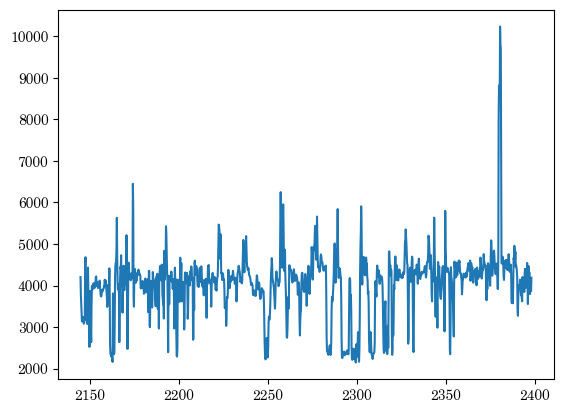

In [112]:
plt.plot(wells[2].data["time"], 1e6/wells[2].data["dtp"])

In [128]:
"""np.r_ is a short concatenation method"""
x_decimated = [np.r_['r', interp(wells[i].data["time"], 1e6/wells[i].data["x"], 2, kind = "nearest-up")].T for i in range(dir_df.shape[0])]

y_decimated = [np.r_['r', interp(wells[i].data["time"], 1e6/wells[i].data["y"], 2, kind = "nearest-up")].T for i in range(dir_df.shape[0])]

dtp_decimated = [np.r_['r', interp(wells[i].data["time"], 1e6/wells[i].data["dtp"], 2, kind = "nearest-up")].T for i in range(dir_df.shape[0])]

rhob_decimated = [np.r_['r', interp(wells[i].data["time"], wells[i].data["rhob"], 2, kind = "nearest-up")].T for i in range(dir_df.shape[0])]

In [129]:
# for i in range(dir_df.shape[0]):
#     len_rhob = len(rhob_decimated[i])
#     len_dtp = len(dtp_decimated[i])

#     if (len_dtp > len_rhob):
#         dtp_decimated[i] = dtp_decimated[i][:len_rhob, :] 
#     else:
#         rhob_decimated[i] = rhob_decimated[i][:len_dtp, :]



In [130]:
"""
18/04/2024
Закончил на том, что сделал децимацию каротажек и продумал обрезку по самой короткой из двух
Дальше нужно перевести медленность в скорость (ПРАВИЛЬНО!) и посчитать импеданс
Пришить это все к глубинам 
Расчитать inline/crossline для каждой скважины (интерполяция инклинометрии)
31 индекс косячный, посмотреть (kaz_K21_294)

19/04/2024
Переписал логику под ООП, теперь каждая скважина - объект, имеющий свои атрибуты. 
Так удобно работать, больше контроля над данными и можно избежать тупых факапов 
(как например с переводом медленности в скорость)
Перевел скорости в медленности и расчитал импеданс для каждой скважины,
запросил уточнения по выбросу в скважине kaz_K21_294 и по поводу пустого файла

Дальше:
Перевод inline/crossline, добавить как атрибуты класса
Разбиение на интервалы
Интерполяция (создание НЧМ)


""" 

'\n18/04/2024\nЗакончил на том, что сделал децимацию каротажек и продумал обрезку по самой короткой из двух\nДальше нужно перевести медленность в скорость (ПРАВИЛЬНО!) и посчитать импеданс\nПришить это все к глубинам \nРасчитать inline/crossline для каждой скважины (интерполяция инклинометрии)\n31 индекс косячный, посмотреть (kaz_K21_294)\n\n19/04/2024\nПереписал логику под ООП, теперь каждая скважина - объект, имеющий свои атрибуты. \nТак удобно работать, больше контроля над данными и можно избежать тупых факапов \n(как например с переводом медленности в скорость)\nПеревел скорости в медленности и расчитал импеданс для каждой скважины,\nзапросил уточнения по выбросу в скважине kaz_K21_294 и по поводу пустого файла\n\nДальше:\nПеревод inline/crossline, добавить как атрибуты класса\nРазбиение на интервалы\nИнтерполяция (создание НЧМ)\n\n\n'

In [131]:
ai_decimated = [np.array(dtp_decimated[i][:, 1])*np.array(rhob_decimated[i][:, 1]) for i in range(dir_df.shape[0])]

In [132]:
for i in range(dir_df.shape[0]):
    wells[i].data_decimated = {"dtp": dtp_decimated[i], "rhob": rhob_decimated[i]}
    wells[i].data_decimated = {
                "x" : x_decimated[i][:, 1],
                "y" : y_decimated[i][:, 1],
                "time" : y_decimated[i][:, 0],
                "dtp" : dtp_decimated[i][:, 1],
                "rhob" : rhob_decimated[i][:, 1],
                "impedance" : ai_decimated[i]
                }

Казанская 16р_DTp.txt
Казанская 18р_DTp.txt
Казанская 19р_DTp.txt
Казанская 20р_DTp.txt
Казанская_К18 309_DTp.txt
Казанская_К18 310_DTp.txt
Казанская_К18 311_DTp.txt


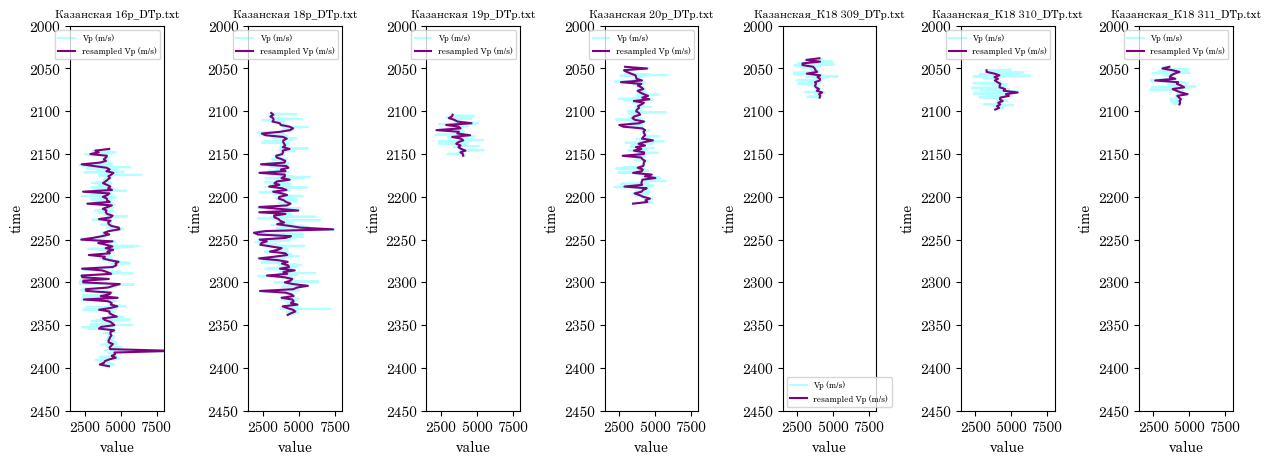

In [176]:
plt.figure(figsize = (15, 5))

w_num =  2
for i in range(2, 9, 1):
    plt.subplot(1, 7, i - 1)
    plt.subplots_adjust(wspace=0.9, hspace=0.4)
    print(wells[i].name_dtp)

    plt.plot(1e6/wells[i].data["dtp"], wells[i].data["time"],  c = "aqua", alpha = .3, label = "Vp (m/s)")
    plt.plot(wells[i].data_decimated["dtp"], wells[i].data_decimated["time"], c = "purple",  label = "resampled Vp (m/s)")

   
    plt.ylim([2000, 2450])
    plt.xlim([1500, 8000])
    plt.gca().invert_yaxis()
    plt.legend(loc = 0, fontsize = 6)
    plt.title("%16s" % wells[i].name_dtp, fontsize = 8)
    plt.ylabel("time")
    plt.xlabel("value")


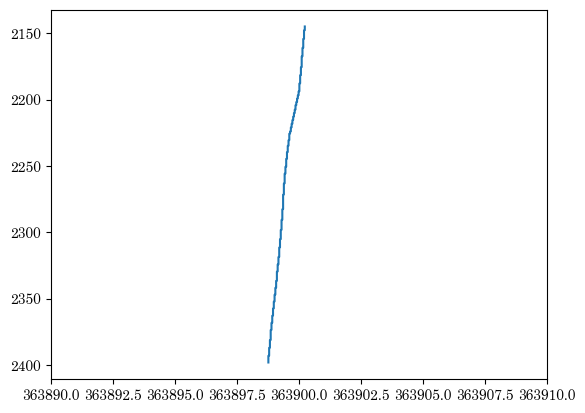

In [351]:
plt.plot(dtp[2][:, 0], dtp[2][:, 2])
plt.xlim([3.6389*1e5, 3.6391*1e5])
plt.gca().invert_yaxis()